In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import joblib
import sys
from glob import glob 
import random

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.errors import ShapelyDeprecationWarning
import warnings
warnings.simplefilter("ignore", category=ShapelyDeprecationWarning)


sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
import helper
import data_preprocessing_helpers
from data_preprocessing_helpers import get_cross_section_data

sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_crossec_fct import plot_cross_section
from plot_crosec_rf_evaluation import plot_crossec_rf_eval

import plot_helpers
import make_plots_traj


sys.path.append('/home/freimax/msc_thesis/scripts/IFS-18/')
import traj_processing_functions

In [3]:
model_tsubsi, model_tmeltsi, model_tevr = helper.load_rf_models()

                   *** Load Models ***                    
  Load model tsubsi
  Load model tmeltsi
  Load model tevr


In [4]:
# ## Load ifs files
# # path_ifs = '/net/thermo/atmosdyn/atroman/PAC1d/cdf/2017/04'
# path_ifs = '/net/thermo/atmosdyn/atroman/PAC1d/cdf'
# path_era = '/net/thermo/atmosdyn/era5/cdf/2017/04'

# date = '20170410_16'
# date_list = ['20170409_15','20170410_03','20170410_16']

# lon_range,lat_range = [130,-150], [20,60]

# ## IFS
# paths_p_ifs = [f'{path_ifs}/P{date}' for date in date_list]
# paths_s_ifs = [f'{path_ifs}/S{date}' for date in date_list]

# print('Load P-files (IFS)')
# # ds_p = xr.load_dataset(f'{path_ifs}/P{date}')
# dropvars_list=[ 'tfrz','trime','udotconv','vdotconv','udotmix','vdotmix','tls','tce', 'BLH','tsw','tlw','tmix','tconv','tcond','tdep','tbf','tevc',]
# ds_p = xr.open_mfdataset(paths_p_ifs, drop_variables=dropvars_list)
# print('Load S-files (IFS)')
# # ds_s = xr.load_dataset(f'{path_ifs}/S{date}')
# ds_s = xr.open_mfdataset(paths_s_ifs)
# # Create lon and lat arrays based on the resolution provided
# lon = np.linspace(-180, 180, ds_s.dimx_PS.size, endpoint=True)
# lat = np.linspace(-90, 90, ds_s.dimy_PS.size, endpoint=True) 
# # Replace existing coordinates and rename them
# ds_s = ds_s.assign_coords({'dimx_PS': lon, 'dimy_PS': lat})
# ds_s = ds_s.rename({'dimx_PS': 'lon', 'dimy_PS': 'lat', 'dimz_P':'lev'})


# ds_ifs = ds_p.copy()
# ds_ifs['THE'] = ds_s['THE'].assign_coords(ds_ifs.coords)
# ds_ifs['TH'] = ds_s['TH'].assign_coords(ds_ifs.coords)
# ds_ifs['RH'] = ds_s['RH'].assign_coords(ds_ifs.coords)
# ds_ifs['tmeltsi']= ds_ifs['tmelti']+ ds_ifs['tmelts']
# ds_ifs['tsubsi'] = ds_ifs['tsubi'] + ds_ifs['tsubs']
# ds_ifs['SIWC']   = ds_ifs['SWC']   + ds_ifs['IWC']
# ds_ifs['total_precip'] = (ds_ifs['LSP'] + ds_ifs['CP']).where((ds_ifs['LSP'] + ds_ifs['CP'])>=0.2)
# ds_ifs = ds_ifs.drop_vars(['tsubs', 'tsubi', 'tmelts','tmelti'])
# ds_ifs = ds_ifs.squeeze()
# ds_ifs = data_preprocessing_helpers.get_lonlatbox(ds_ifs, lon_range=lon_range, lat_range=lat_range)



# # ERA5
# print('Load ERA5')
# # ds_p_era = xr.load_dataset(f'{path_era}/P{date}')
# paths_p_era = [f'{path_era}/P{date}' for date in date_list]
# ds_p_era = xr.open_mfdataset(paths_p_era)
# # ds_s_era = xr.load_dataset(f'{path_era}/S{date}')
# paths_s_era = [f'{path_era}/S{date}' for date in date_list]
# ds_s_era = xr.open_mfdataset(paths_s_era)
# ## Load B file for SLP
# paths_b_era = [f'{path_era}/B{date}' for date in date_list]
# dropvar_list2 = ['PS','TCC','U10M','V10M','SSTK','CI','D2M','T2M','TCW','TCWV','VIWVD','E','MN2T','MX2T','SI','TTR','TTRC','WG10','LSP','CP','SF','SSHF','SLHF','BLH']
# slp_era = xr.open_mfdataset(paths_b_era, drop_variables=dropvar_list2)

# ds_era = ds_p_era.copy()
# ds_era['THE'] = ds_s_era['THE'].assign_coords(ds_era.coords)
# ds_era['TH'] = ds_s_era['TH'].assign_coords(ds_era.coords)
# ds_era['RH']  = ds_s_era['RH'].assign_coords(ds_era.coords)
# ds_era['SLP'] = slp_era['MSL']/100
# ds_era['T']   = ds_era['T']-273.15
# ds_era['RWC'] = ds_era['RWC']*1000
# ds_era['SWC'] = ds_era['SWC']*1000
# ds_era['IWC'] = ds_era['IWC']*1000
# ds_era['LWC'] = ds_era['LWC']*1000
# ds_era['total_precip'] = ((ds_era['LSP']*1000 + ds_era['CP']*1000).where((ds_era['LSP']*1000 + ds_era['CP']*1000)>=0.2))
# ds_era = ds_era.squeeze()
# ds_era = data_preprocessing_helpers.get_lonlatbox(ds_era, lon_range=lon_range, lat_range=lat_range)

# ## Calculate 3d pressure fields (pressure between all the model-levels)
# hya_cut = ds_p_era.hyam.isel(time=0).values[np.arange((137-ds_era.lev.shape[0]),137)]
# hyb_cut = ds_p_era.hybm.isel(time=0).values[np.arange((137-ds_era.lev.shape[0]),137)]

# pres_field3d_era = data_preprocessing_helpers.PRES_3d_era5(data_set_PS=ds_era, shape_var=ds_era['T'], hya=hya_cut, hyb=hyb_cut)
# ## Interpolate variables to pressure levels
# ds_era_pres = data_preprocessing_helpers.interpolate_pres(data=ds_era, pres_field=pres_field3d_era, pressure_levels=np.arange(1030,190,-10))
# ds_era_pres['SLP'] = ds_era['SLP']

# ## Calculate 3d pressure fields (pressure between all the model-levels)
# pres_field3d_ifs = data_preprocessing_helpers.PRES_3d(ds_ifs, shape_var=ds_ifs['T'])
# ## Interpolate variables to pressure levels
# ds_ifs_pres = data_preprocessing_helpers.interpolate_pres(data=ds_ifs, pres_field=pres_field3d_ifs, pressure_levels=np.arange(1020,190,-10))
# ds_ifs_pres['SLP'] = ds_ifs['SLP']

In [5]:
# ifs_ds = xr.open_mfdataset(paths_p_ifs)
# ifs_ds = ifs_ds.squeeze()
# ifs_pres = data_preprocessing_helpers.PRES_3d(ifs_ds, shape_var=ifs_ds['T'])


In [6]:
# ifs_pres.isel(lev=82).mean(dim=['time','lon','lat'])

In [7]:
## Load ifs files
# path_ifs = '/net/thermo/atmosdyn/atroman/PAC1d/cdf/2017/04'
path_ifs = '/net/thermo/atmosdyn/atroman/PAC1d/cdf'
path_era = '/net/thermo/atmosdyn/era5/cdf/2017/04'

date_list = ['20170409_15','20170410_03','20170410_16']

lon_range,lat_range = [130,-150], [20,60]

## IFS
paths_p_ifs = [f'{path_ifs}/P{date}' for date in date_list]
paths_s_ifs = [f'{path_ifs}/S{date}' for date in date_list]

print('Load and Process IFS')
# ds_p = xr.load_dataset(f'{path_ifs}/P{date}')
dropvars_list=[ 'tfrz','trime','udotconv','vdotconv','udotmix','vdotmix','tls','tce', 'BLH','tsw','tlw','tmix','tconv','tcond','tdep','tbf','tevc',]
ds_p = xr.open_mfdataset(paths_p_ifs, drop_variables=dropvars_list)
# ds_s = xr.load_dataset(f'{path_ifs}/S{date}')
ds_s = xr.open_mfdataset(paths_s_ifs)
# Create lon and lat arrays based on the resolution provided
lon = np.linspace(-180, 180, ds_s.dimx_PS.size, endpoint=True)
lat = np.linspace(-90, 90, ds_s.dimy_PS.size, endpoint=True) 
# Replace existing coordinates and rename them
ds_s = ds_s.assign_coords({'dimx_PS': lon, 'dimy_PS': lat})
ds_s = ds_s.rename({'dimx_PS': 'lon', 'dimy_PS': 'lat', 'dimz_P':'lev'})


ds_ifs = ds_p.copy()
ds_ifs['THE'] = ds_s['THE'].assign_coords(ds_ifs.coords)
ds_ifs['TH'] = ds_s['TH'].assign_coords(ds_ifs.coords)
ds_ifs['PV'] = ds_s['PV'].assign_coords(ds_ifs.coords)
ds_ifs['RH'] = ds_s['RH'].assign_coords(ds_ifs.coords)
ds_ifs['SIWC']   = ds_ifs['SWC']   + ds_ifs['IWC']
ds_ifs['total_precip'] = (ds_ifs['LSP'] + ds_ifs['CP']).where((ds_ifs['LSP'] + ds_ifs['CP'])>=0.2)
ds_ifs['tsubsi'] = ds_ifs['tsubi'] + ds_ifs['tsubs']
ds_ifs['tmeltsi']= ds_ifs['tmelti']+ ds_ifs['tmelts']
ds_ifs = ds_ifs.drop_vars(['tsubs', 'tsubi', 'tmelts','tmelti'])
ds_ifs = ds_ifs.squeeze()
ds_ifs = data_preprocessing_helpers.get_lonlatbox(ds_ifs, lon_range=lon_range, lat_range=lat_range)

## Make predictions for corss-section data
features = ['SIWC','LWC','RWC','RH','Q','OMEGA','T']
tsubsi_pred = rf_functions.make_predictions( ds_ifs, model_tsubsi , water_type='SIWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=False)
tmeltsi_pred = rf_functions.make_predictions(ds_ifs, model_tmeltsi, water_type='SIWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=True)
tevr_pred = rf_functions.make_predictions(   ds_ifs, model_tevr   , water_type='RWC' , feature_names=features, type_filteredvalues='nan', add_temp_filter=False)

ds_ifs['tsubsi_pred'] = tsubsi_pred.assign_coords(ds_ifs.coords)
ds_ifs['tmeltsi_pred']= tmeltsi_pred.assign_coords(ds_ifs.coords)
ds_ifs['tevr_pred']   = tevr_pred.assign_coords(ds_ifs.coords)




# ERA5
print('\n================================================================================================')
print('Load and process ERA5')
# ds_p_era = xr.load_dataset(f'{path_era}/P{date}')
paths_p_era = [f'{path_era}/P{date}' for date in date_list]
ds_p_era = xr.open_mfdataset(paths_p_era)
# ds_s_era = xr.load_dataset(f'{path_era}/S{date}')
paths_s_era = [f'{path_era}/S{date}' for date in date_list]
ds_s_era = xr.open_mfdataset(paths_s_era)
## Load B file for SLP
paths_b_era = [f'{path_era}/B{date}' for date in date_list]
dropvar_list2 = ['PS','TCC','U10M','V10M','SSTK','CI','D2M','T2M','TCW','TCWV','VIWVD','E','MN2T','MX2T','SI','TTR','TTRC','WG10','LSP','CP','SF','SSHF','SLHF','BLH']
slp_era = xr.open_mfdataset(paths_b_era, drop_variables=dropvar_list2)

ds_era = ds_p_era.copy()
ds_era['THE'] = ds_s_era['THE'].assign_coords(ds_era.coords)
ds_era['TH'] = ds_s_era['TH'].assign_coords(ds_era.coords)
ds_era['PV'] = ds_s_era['PV'].assign_coords(ds_era.coords)
ds_era['RH']  = ds_s_era['RH'].assign_coords(ds_era.coords)
ds_era['SLP'] = slp_era['MSL']/100
ds_era['T']   = ds_era['T']-273.15
ds_era['RWC'] = ds_era['RWC']*1000
ds_era['SWC'] = ds_era['SWC']*1000
ds_era['IWC'] = ds_era['IWC']*1000
ds_era['SIWC'] = ds_era['SWC'] + ds_era['IWC']
ds_era['LWC'] = ds_era['LWC']*1000
ds_era['total_precip'] = ((ds_era['LSP']*1000 + ds_era['CP']*1000).where((ds_era['LSP']*1000 + ds_era['CP']*1000)>=0.2))
ds_era = ds_era.squeeze()
ds_era = data_preprocessing_helpers.get_lonlatbox(ds_era, lon_range=lon_range, lat_range=lat_range)

## Make predictions for corss-section data
features = ['SIWC','LWC','RWC','RH','Q','OMEGA','T']
tsubsi_pred = rf_functions.make_predictions( ds_era, model_tsubsi , water_type='SIWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=False)
tmeltsi_pred = rf_functions.make_predictions(ds_era, model_tmeltsi, water_type='SIWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=True)
tevr_pred = rf_functions.make_predictions(   ds_era, model_tevr   , water_type='RWC' , feature_names=features, type_filteredvalues='nan', add_temp_filter=False)

ds_era['tsubsi_pred'] = tsubsi_pred.assign_coords(ds_era.coords)
ds_era['tmeltsi_pred']= tmeltsi_pred.assign_coords(ds_era.coords)
ds_era['tevr_pred']   = tevr_pred.assign_coords(ds_era.coords)


## Calculate 3d pressure fields (pressure between all the model-levels)
hya_cut = ds_p_era.hyam.isel(time=0).values[np.arange((137-ds_era.lev.shape[0]),137)]
hyb_cut = ds_p_era.hybm.isel(time=0).values[np.arange((137-ds_era.lev.shape[0]),137)]


## Calculate 3d pressure fields (pressure between all the model-levels)
pres_field3d_ifs = data_preprocessing_helpers.PRES_3d(ds_ifs, shape_var=ds_ifs['T'])
## Interpolate variables to pressure levels
ds_ifs_pres = data_preprocessing_helpers.interpolate_pres(data=ds_ifs, pres_field=pres_field3d_ifs, pressure_levels=np.arange(1020,190,-10))
ds_ifs_pres['SLP'] = ds_ifs['SLP']

pres_field3d_era = data_preprocessing_helpers.PRES_3d_era5(data_set_PS=ds_era, shape_var=ds_era['T'], hya=hya_cut, hyb=hyb_cut)
## Interpolate variables to pressure levels
ds_era_pres = data_preprocessing_helpers.interpolate_pres(data=ds_era, pres_field=pres_field3d_era, pressure_levels=np.arange(1030,190,-10))
ds_era_pres['SLP'] = ds_era['SLP']


Load and Process IFS


===================================================     Make RF Predictions     ===================================================
Create flattened features datframe
Drop all points where SIWC == 0
Reshape predictions to 4d data-array with shape (3, 83, 101, 201).		Filtered values are set to NaN
===================================================     Make RF Predictions     ===================================================
Create flattened features datframe
Drop all points where SIWC == 0 and Temp < 0
Reshape predictions to 4d data-array with shape (3, 83, 101, 201).		Filtered values are set to NaN
===================================================     Make RF Predictions     ===================================================
Create flattened features datframe
Drop all points where RWC == 0
Reshape predictions to 4d data-array with shape (3, 83, 101, 201).		Filtered values are set to NaN

Load and process ERA5
===================================================     Make RF Predict

Interpolating to pressure levels: 100%|██████████| 3/3 [00:24<00:00,  8.02s/it]


In [8]:
ifs_2pvu_320k = data_preprocessing_helpers.interpolate_pres(data=ds_ifs, 
                                                      pres_field=ds_ifs['TH'], 
                                                      pressure_levels=[320], varlist=['PV'])

era_2pvu_320k = data_preprocessing_helpers.interpolate_pres(data=ds_era, 
                                                      pres_field=ds_era['TH'], 
                                                      pressure_levels=[320], varlist=['PV'])

Interpolating to pressure levels: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


In [9]:
# ifs_2pvu_320k.PV
# plt.show()
# era_2pvu_320k.PV.plot()

In [10]:
def plot_synoptic_subplot(ax, slp, the, tot_rain, cmap, norm, pv_tp=False, xcoords=True, ycoords=True):

    # Set coastlines and hide default ticks produced by matplotlib
    ax.coastlines()
    ax.set_xticklabels([] ); ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('none') ; ax.yaxis.set_ticks_position('none')

    # Gridlines setup
    xticks = np.arange(-180, 181, 20)
    yticks = np.arange(-90, 91, 15)
   
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=xticks, ylocs=yticks)
    
    if not xcoords:
        gl.bottom_labels=False   ;    gl.top_labels=False  ;  gl.right_labels=False    
        gl.xformatter=LONGITUDE_FORMATTER    ;    gl.yformatter=LATITUDE_FORMATTER
    if not ycoords:
        gl.left_labels=False   ;    gl.top_labels=False  ;  gl.right_labels=False    
        gl.xformatter=LONGITUDE_FORMATTER    ;    gl.yformatter=LATITUDE_FORMATTER

    gl.top_labels=False  ;  gl.right_labels=False   ;   gl.xformatter=LONGITUDE_FORMATTER    ;    gl.yformatter=LATITUDE_FORMATTER
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())   ;   ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    # Plot contour for SLP
    c_slp = ax.contour(slp['lon'], slp['lat'], slp, transform=ccrs.PlateCarree(), 
                       colors='k', linewidths=0.75, alpha=0.95, zorder=2)
    ax.clabel(c_slp, inline=1, fontsize=10)
    
    c_2pvu = ax.contour(pv_tp['lon'], pv_tp['lat'], pv_tp, transform=ccrs.PlateCarree(), 
                        colors='green', linewidths=3, alpha=0.99, zorder=3, levels=[2])
    
    # Plot the THE
    img_the = ax.pcolormesh(the['lon'], the['lat'], the, transform=ccrs.PlateCarree(), 
                            shading='auto', cmap='autumn_r', alpha=0.85)  #plasma, 

    # Plot total precipitation
    img_tpr = ax.pcolormesh(tot_rain['lon'],tot_rain['lat'],tot_rain, transform=ccrs.PlateCarree(), zorder=1, cmap=cmap, norm=norm, alpha=0.7)

    return c_slp, img_the, img_tpr

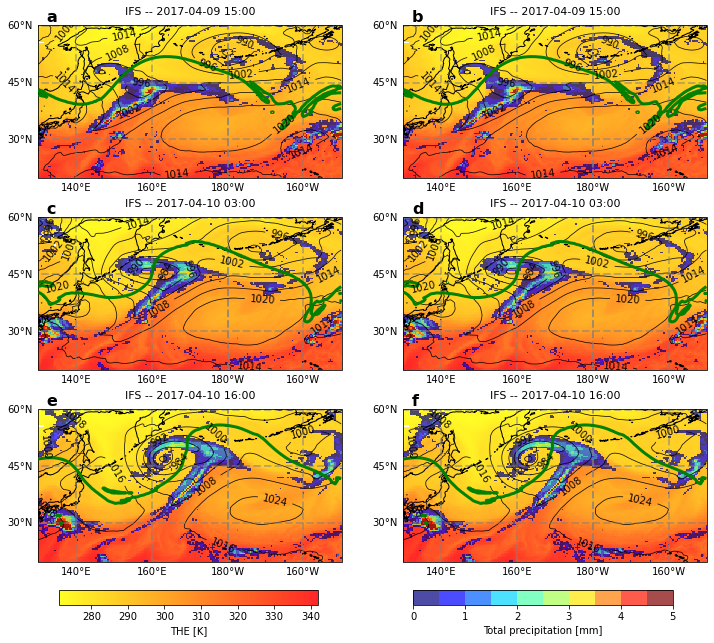

In [19]:
## Plot synoptic overview
fig,axes = plt.subplots(figsize=(12,10),
                        nrows=3,
                        ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        ) 

levels = MaxNLocator(nbins=10).tick_values(0.2, 5)
cmap   = plt.colormaps['jet']
norm   = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)


for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        ## Add title at top
        set_xcoord, set_ycoord = True, True
        # if col == 0:
        slp = ds_ifs['SLP'].isel(time=row)
        the = ds_ifs_pres['THE'].isel(time=row).sel(level=slice(950,850)).mean(dim='level')
        tot_rain = ds_ifs['total_precip'].isel(time=row)
        pv_tp = ifs_2pvu_320k.isel(time=row).PV
        title = f'IFS -- {str(slp.time.values)[0:10]} {str(slp.time.values)[11:16]}'            
        # elif col ==1:
        #     slp = ds_era['SLP'].isel(time=row)
        #     the = ds_era_pres['THE'].isel(time=row).sel(level=slice(950,850)).mean(dim='level')
        #     tot_rain = ds_era['total_precip'].isel(time=row)
        #     pv_tp = era_2pvu_320k.isel(time=row).PV
        #     title = f'ERA5 -- {str(slp.time.values)[0:10]} {str(slp.time.values)[11:16]}'
        #     set_ycoord = False
        
        if row == 2:
            set_xcoord = True

        ## Create plot
        c_slp, img_the, img_tpr = plot_synoptic_subplot(ax=axes[row,col], slp=slp, the=the, 
                                                        xcoords=set_xcoord, ycoords=set_ycoord,
                                                        tot_rain=tot_rain, cmap=cmap, norm=norm, pv_tp=pv_tp)
        # Title is model and date-time
        axes[row, col].set_title(title, fontsize=11)


cax_the = fig.add_axes([0.15, 0.07, 0.3, 0.02]) # [left, bottom, width, height]
cbar_the = fig.colorbar(img_the, cax=cax_the, orientation='horizontal')#, pad=0.1, aspect=40)
cbar_the.set_label('THE [K]')

cax_tpr = fig.add_axes([0.56, 0.07, 0.3, 0.02]) # [left, bottom, width, height]
cbar_tpr = fig.colorbar(img_tpr, cax=cax_tpr, orientation='horizontal')#, pad=0.1, aspect=40)
cbar_tpr.set_label('Total precipitation [mm]')



# Add labels to each subplot
labels = [['a', 'b'], ['c', 'd'], ['e', 'f']]
for row in range(3):
    for col in range(2):
        label= labels[row][col]
        axes[row,col].text(0.03, 1.0, label, transform=axes[row,col].transAxes, 
        color='k', fontsize=16, fontweight='bold', va='bottom')

plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_casestudy/synoptic_overview.png', 
            bbox_inches='tight', 
            dpi=200)



In [11]:
##Prepare data
#cold-front-cut

lon_start1, lon_end1 = 165.0 , 173.0    #
lat_start1, lat_end1 =  45.0 ,  37.0    #

## Create a list for all lon and lats values
lon_starts = [lon_start1]
lon_ends   = [lon_end1]
lat_starts = [lat_start1]
lat_ends   = [lat_end1]

cf_start = [lat_start1, lon_start1]
cf_end   = [lat_end1, lon_end1]

ifs_crosec_data = get_cross_section_data(ds_ifs_pres.isel(time=2), start=cf_start, end=cf_end, timestep=None)
era_crosec_data = get_cross_section_data(ds_era_pres.isel(time=2), start=cf_start, end=cf_end, timestep=None, era5_data=True)

ifs_data_p  = ifs_crosec_data.get('data_p')
ifs_cross_p = ifs_crosec_data.get('cross_p')

era_data_p  = era_crosec_data.get('data_p')
era_cross_p = era_crosec_data.get('cross_p')

Plot colorbar with iD: cbar_RH
Plot Contour isotherms
Plot Contour TH
Plot Contour isotherms
Plot Contour TH


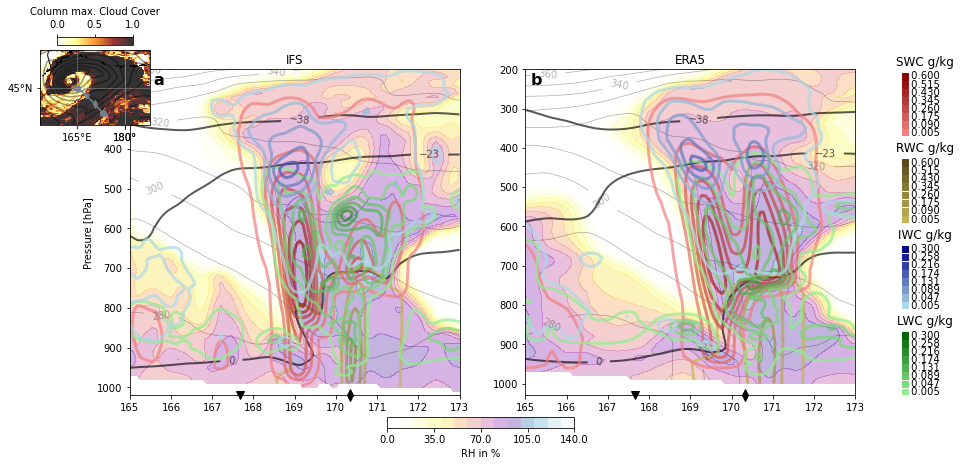

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(13,6))

plot_cross_section(ifs_cross_p, 
                    ifs_data_p, 
                    ax=ax[0],
                    start=cf_start, end=cf_end,
                    plot_contourf=['RH'], plot_contour=['isotherms', 'TH'],
                    show_wind_barbs=False, show_clouds=[True,True],show_precip=[True,False], inset_contourf='max_cc',
                    contourf_colorbar=True,
                    rf_bcp = False,
                    flag_1cb=True
                    )

ax[0].set_title('IFS')
plot_cross_section(era_cross_p, 
                    era_data_p, 
                    ax=ax[1],
                    start=cf_start, end=cf_end,
                    plot_contourf=['RH'], plot_contour=['isotherms', 'TH'],
                    show_wind_barbs=False, show_clouds=[True,False],show_precip=[True,True], inset_contourf=False,
                    contourf_colorbar=False,
                    rf_bcp = False,
                    flag_1cb=True,
                    )
ax[1].set_title('ERA5')

ax[0].set_ylabel('Pressure [hPa]')
# ax[0].set_xlabel('Lon')
# ax[1].set_xlabel('Lon')

# Add labels to each subplot
labels = ['a', 'b']
x_pos  = [0.07, 0.015]
for col in range(2):
    label= labels[col]
    ax[col].text(x_pos[col], 0.99, label, transform=ax[col].transAxes, fontsize=16, fontweight='bold', va='top')



plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_casestudy/crosec_from{cf_start}_to{cf_end}_coldfront_cloud_precip_t{ifs_cross_p["time"].dt.strftime("%Y%m%d-%H").item()}.png', 
            bbox_inches='tight', 
            dpi=250)


In [10]:
# model_tsubsi, model_tmeltsi, model_tevr = helper.load_rf_models()

# ## Make predictions for corss-section data
# features = ['SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']
# tsubsi_pred = rf_functions.make_predictions(ds_ifs_pres, model_tsubsi, water_type='SIWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=False)
# ds_ifs_pres['tsubsi_pred'] = tsubsi_pred.assign_coords(ds_ifs_pres.coords)

# tmeltsi_pred = rf_functions.make_predictions(ds_ifs_pres, model_tmeltsi, water_type='SIWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=True)
# ds_ifs_pres['tmeltsi_pred'] = tmeltsi_pred.assign_coords(ds_ifs_pres.coords)

# tevr_pred = rf_functions.make_predictions(ds_ifs_pres, model_tevr, water_type='RWC', feature_names=features, type_filteredvalues='nan', add_temp_filter=False)
# ds_ifs_pres['tevr_pred'] = tevr_pred.assign_coords(ds_ifs_pres.coords)

In [13]:
## Prepare data
lon_start1, lon_end1 = 165.0,173.0    #
lat_start1, lat_end1 =  45.0,37.0    #
cf_start = [lat_start1,lon_start1]
cf_end   = [lat_end1,lon_end1]

ifs_crosec_data = get_cross_section_data(ds_ifs_pres.isel(time=2), start=cf_start, end=cf_end, timestep=None)
ifs_data_p  = ifs_crosec_data.get('data_p')
ifs_cross_p = ifs_crosec_data.get('cross_p')

era_crosec_data = get_cross_section_data(ds_era_pres.isel(time=2), start=cf_start, end=cf_end, timestep=None, era5_data=True)
era_data_p  = era_crosec_data.get('data_p')
era_cross_p = era_crosec_data.get('cross_p')


Plot with lon/lat: 165.0/45.0 to 173.0/37.0


/home/freimax/msc_thesis/scripts/plotting_functions/plot_crosec_rf_evaluation.py:353: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 290, -100))
/home/freimax/msc_thesis/scripts/plotting_functions/plot_crosec_rf_evaluation.py:353: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 290, -100))
/home/freimax/msc_thesis/scripts/plotting_functions/plot_crosec_rf_evaluation.py:353: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 290, -100))
/home/freimax/msc_thesis/scripts/plotting_functions/plot_crosec_rf_evaluation.py:353: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 290, -100))


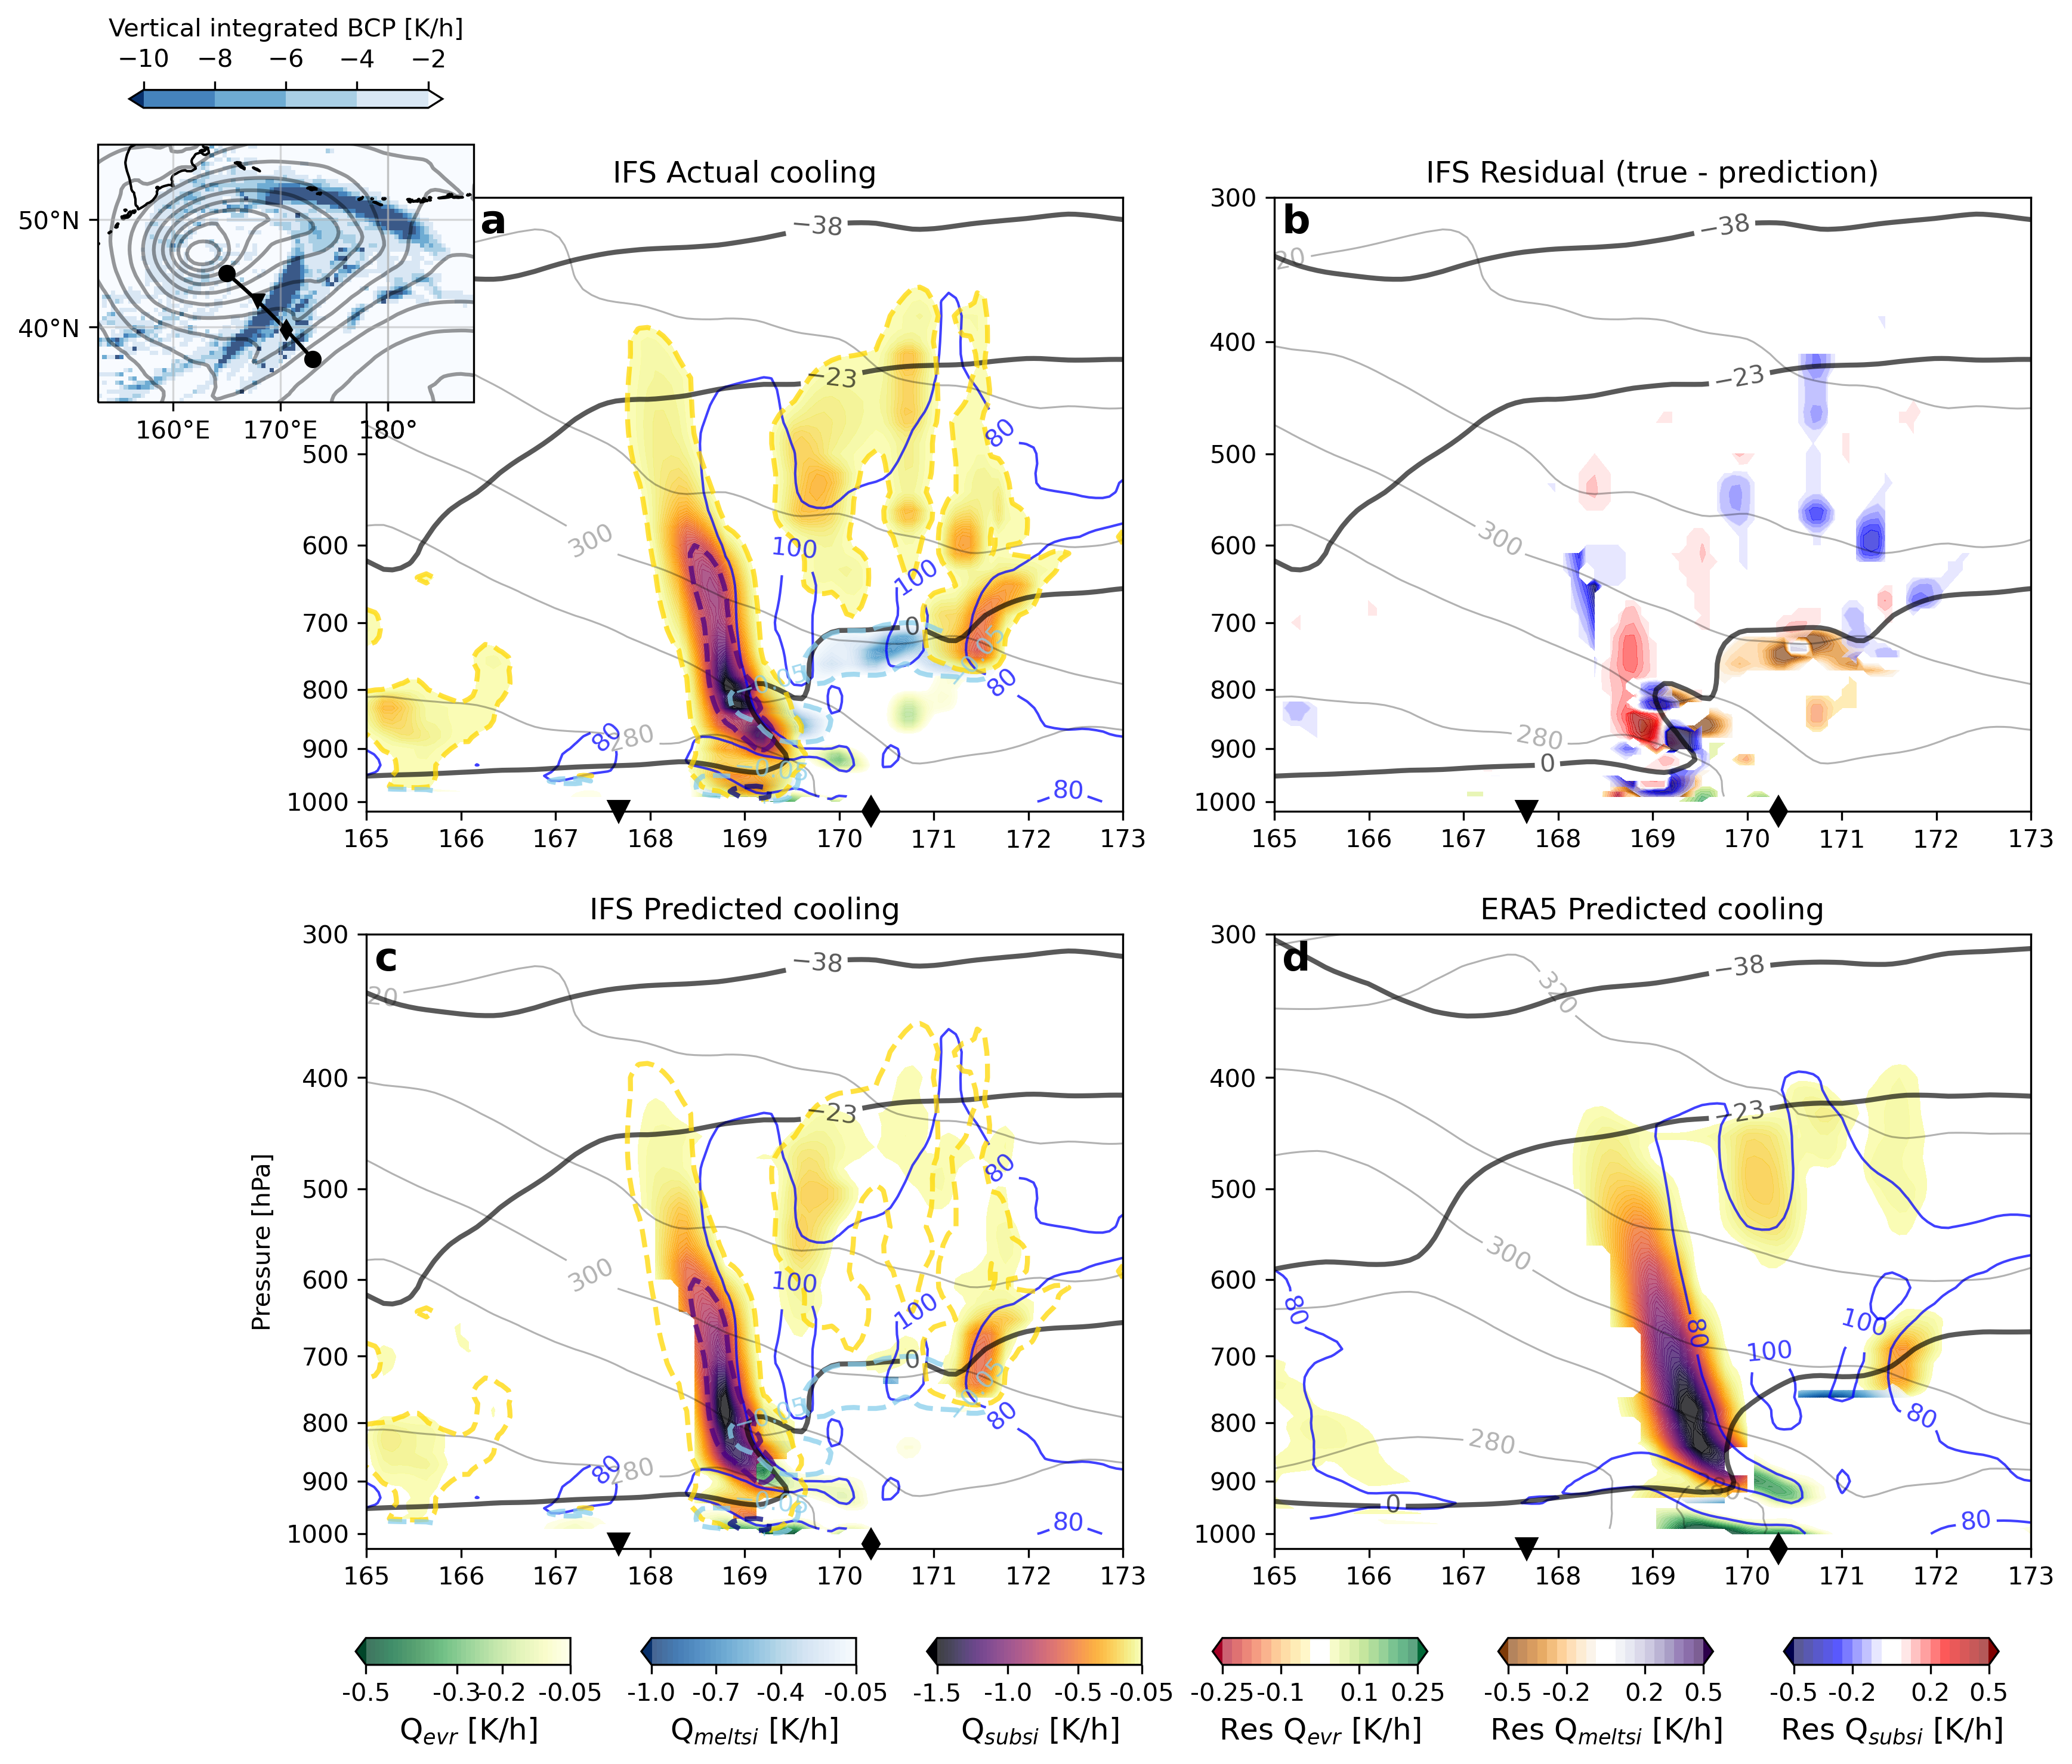

In [14]:
# Define time-step                    #
timestep = '20170410_16'            #

## Choose contourf and contour
plot_cf1 = ['tsubsi', 'tmeltsi', 'tevr'][::-1]
plot_c1  = [ 'RH', 'TH', 'isotherms', 'tsubsi_thr_weak', 'tsubsi_thr_strong', 'tmeltsi_thr_weak', 'tmeltsi_thr_strong']

plot_cf2 = ['residual_tsubsi', 'residual_tmeltsi', 'residual_tevr'][::-1]
plot_c2  = ['TH', 'isotherms', ]

plot_cf3 = ['tsubsi_pred', 'tmeltsi_pred', 'tevr_pred'][::-1]
plot_c3  = [ 'RH', 'TH', 'isotherms', 'tsubsi_thr_weak', 'tsubsi_thr_strong', 'tmeltsi_thr_weak', 'tmeltsi_thr_strong']

plot_cf4 = ['tsubsi_pred', 'tmeltsi_pred', 'tevr_pred']
plot_c4  = [ 'RH', 'TH', 'isotherms', ]#'tsubsi_thr_weak', 'tsubsi_thr_strong', 'tmeltsi_thr_weak', 'tmeltsi_thr_strong']
########################################################################################################



# for lons, lats, lone, late in zip(lon_starts, lat_starts, lon_ends, lat_ends):
#     start = (lats, lons)
#     end = (late, lone)

lon_start1, lon_end1 = 165.0,173.0    #
lat_start1, lat_end1 =  45.0,37.0    #

## Create a list for all lon and lats values
lon_starts = [lon_start1]
lon_ends   = [lon_end1]
lat_starts = [lat_start1]
lat_ends   = [lat_end1]

cf_start = [lat_start1,lon_start1]
cf_end   = [lat_end1,lon_end1]

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------- 
# Create Figure
print(f'\nPlot with lon/lat: {cf_start[1]}/{cf_start[0]} to {cf_end[1]}/{cf_end[0]}')
fig = plt.figure(figsize=(12, 10), dpi=300)
gs = GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1], sharey=ax3)

# # Set the suptitle
# fig.suptitle(f'Cross-Section \u2013 {cf_start} to {cf_end} \u2013 \n'
#             f'Time: {ifs_cross_p["time"].dt.strftime("%Y-%m-%d %H:%M").item()}', fontsize=16, y=1.0)

# Plot  ||  TRUE  |  PRED  |  RESID  ||
img1 = plot_crossec_rf_eval(ax=ax1, cross_p=ifs_cross_p, data_p=ifs_data_p, start=cf_start, end=cf_end, plot_contourf=plot_cf1, plot_contour=plot_c1,    
                            inset_contourf='all_bcp_sums')
ax1.set_title('IFS Actual cooling')

img2 = plot_crossec_rf_eval(ax=ax2, cross_p=ifs_cross_p, data_p=ifs_data_p, start=cf_start, end=cf_end, plot_contourf=plot_cf2, plot_contour=plot_c2,    
                            inset_contourf=False)
ax2.set_title('IFS Residual (true - prediction)')

img3 = plot_crossec_rf_eval(ax=ax3, cross_p=ifs_cross_p, data_p=ifs_data_p, start=cf_start, end=cf_end, plot_contourf=plot_cf3, plot_contour=plot_c3,    
                            inset_contourf=False)    
ax3.set_title('IFS Predicted cooling')

img4 = plot_crossec_rf_eval(ax=ax4, cross_p=era_cross_p, data_p=era_data_p, start=cf_start, end=cf_end, plot_contourf=plot_cf4, plot_contour=plot_c4,    
                            inset_contourf=False)
ax4.set_title('ERA5 Predicted cooling')


# Add labels to each subplot
labels = [['a', 'b'], ['c', 'd']]

axes = [[ax1,ax2],[ax3,ax4]]

for row in range(2):
    for col in range(2):
        label= labels[row][col]
        if (row == 0) & (col == 0):
            axes[row][col].text(0.15, 0.99, label, transform=axes[row][col].transAxes, fontsize=16, fontweight='bold', va='top')
        else:
            axes[row][col].text(0.01, 0.99, label, transform=axes[row][col].transAxes, fontsize=16, fontweight='bold', va='top')

# ax1.set_ylabel('Pressure [hPa]')
ax3.set_ylabel('Pressure [hPa]')

#---------------------------------------------------------------------------------    
plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_casestudy/crosec_rf_from{cf_start}_to{cf_end}_coldfront_t{ifs_cross_p["time"].dt.strftime("%Y%m%d-%H").item()}.png', 
            bbox_inches='tight',
            dpi=300)
plt.show()

In [16]:
ifs_tsubsi_950_700       = ds_ifs_pres['tsubsi'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
ifs_tmeltsi_950_700      = ds_ifs_pres['tmeltsi'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
ifs_tevr_950_700         = ds_ifs_pres['tevr'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
ifs_950_700 = [ifs_tsubsi_950_700, ifs_tmeltsi_950_700, ifs_tevr_950_700]

ifs_tsubsi_pred_950_700  = ds_ifs_pres['tsubsi_pred'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
ifs_tmeltsi_pred_950_700 = ds_ifs_pres['tmeltsi_pred'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
ifs_tevr_pred_950_700    = ds_ifs_pres['tevr_pred'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
ifs_pred_950_700 = [ifs_tsubsi_pred_950_700, ifs_tmeltsi_pred_950_700, ifs_tevr_pred_950_700]

era_tsubsi_pred_950_700  = ds_era_pres['tsubsi_pred'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
era_tmeltsi_pred_950_700 = ds_era_pres['tmeltsi_pred'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
era_tevr_pred_950_700    = ds_era_pres['tevr_pred'].isel(time=2).sel(level=slice(950,700)).mean(dim='level')
era_pred_950_700 = [era_tsubsi_pred_950_700, era_tmeltsi_pred_950_700, era_tevr_pred_950_700]


In [17]:
# def plot_synoptic_bcp_subplot(ax, slp, bcp, cmap, norm, levels):

#     # Set coastlines and hide default ticks produced by matplotlib
#     ax.coastlines()
#     ax.set_xticklabels([] ); ax.set_yticklabels([])
#     ax.xaxis.set_ticks_position('none') ; ax.yaxis.set_ticks_position('none')

#     # Gridlines setup
#     xticks = np.arange(-180, 181, 20)
#     yticks = np.arange(-90, 91, 15)
   
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=xticks, ylocs=yticks)
#     gl.top_labels=False  ;  gl.right_labels=False   ;   gl.xformatter=LONGITUDE_FORMATTER    ;    gl.yformatter=LATITUDE_FORMATTER
#     ax.set_xticks(xticks, crs=ccrs.PlateCarree())   ;   ax.set_yticks(yticks, crs=ccrs.PlateCarree())

#     # Plot contour for SLP
#     c_slp = ax.contour(slp['lon'], slp['lat'], slp, transform=ccrs.PlateCarree(), 
#                        colors='k', linewidths=0.75, alpha=0.95, zorder=2)
#     ax.clabel(c_slp, inline=1, fontsize=10)
#     # Plot the THE
#     img_the = ax.pcolormesh(the['lon'], the['lat'], the, transform=ccrs.PlateCarree(), shading='auto', cmap='autumn_r', alpha=0.85)  #plasma, 

#     # Plot total precipitation
#     img_tpr = ax.pcolormesh(tot_rain['lon'],tot_rain['lat'],tot_rain, transform=ccrs.PlateCarree(), zorder=1, cmap=cmap, norm=norm, alpha=0.7)

#     return c_slp, img_the, img_tpr

In [18]:
slp_ifs = ds_ifs_pres.isel(time=2).SLP
slp_era = ds_era_pres.isel(time=2).SLP

IFS SLP_min:	965.3
ERA SLP_min:	964.0


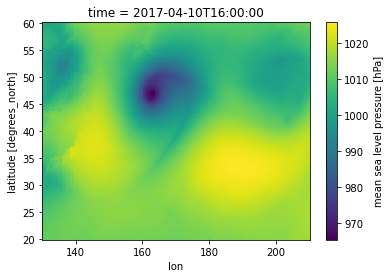

In [19]:
print(f'IFS SLP_min:\t{slp_ifs.values.min():.1f}\nERA SLP_min:\t{slp_era.values.min():.1f}')
slp_ifs.plot()

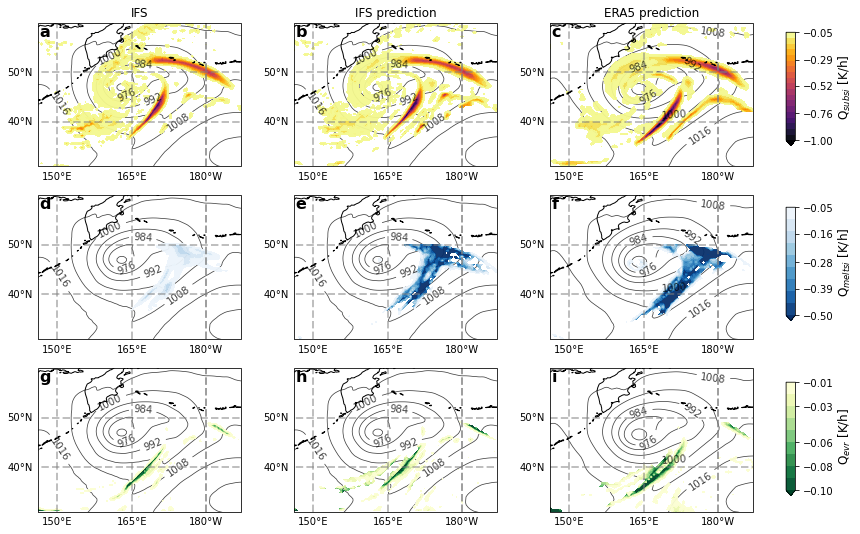

In [20]:
fields = [ifs_950_700, ifs_pred_950_700, era_pred_950_700]
titles = ['IFS', 'IFS prediction', 'ERA5 prediction']
slp = [slp_ifs ,slp_ifs , slp_era]

fig,axes = plt.subplots(nrows=3,ncols=3, 
                        figsize=(13,9),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

lonlatbox = True
lon_min, lon_max = 146, 187
lat_min, lat_max =  31,  60 

cmaps = ['inferno', 'Blues_r', 'YlGn_r']
levels = [np.arange(-1.  ,  0.0 , 0.05), 
          np.arange(-0.5 , -0.0 , 0.05), 
          np.arange(-0.1 , -0.0 , 0.01)]
nr_ticks = [5,5,5]
# levels = MaxNLocator(nbins=10).tick_values(0.2, 5)
# cmap   = plt.colormaps['jet']
# norm   = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

cbar_labels = [r'Q$_{subsi}$ [K/h]', r'Q$_{meltsi}$ [K/h]', r'Q$_{evr}$ [K/h]']

for row in range(3):
    for col in range(3):
        
        ax = axes[row,col]

        # Set coastlines and hide default ticks produced by matplotlib
        ax.coastlines()
        ax.set_xticklabels([] ); ax.set_yticklabels([])
        ax.xaxis.set_ticks_position('none') ; ax.yaxis.set_ticks_position('none')

        # Gridlines setup
        xticks = np.arange(-180, 181, 15)
        yticks = np.arange(-90, 91, 10)
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=xticks, ylocs=yticks)
        gl.top_labels=False  ;  gl.right_labels=False   ;   gl.xformatter=LONGITUDE_FORMATTER    ;    gl.yformatter=LATITUDE_FORMATTER
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())   ;   ax.set_yticks(yticks, crs=ccrs.PlateCarree())

        ## Set the extend of the pltos
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        ## Plot title for first row
        if row == 0:
            ax.set_title(titles[col])
        
        ## Plot RF predicitons
        if lonlatbox:
            field = fields[col][row].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
        else:
            print('Got here?')
            field = fields[col][row]
        img = ax.contourf(
            field['lon'],field['lat'], field, transform=ccrs.PlateCarree(),
            levels=levels[row], cmap=cmaps[row], alpha=0.95, extend='min', zorder=1)

        ## Plot contour for SLP
        c_slp = ax.contour(
            slp[col]['lon'], slp[col]['lat'], slp[col], transform=ccrs.PlateCarree(), 
            colors='k', linewidths=0.75, alpha=0.75, zorder=0)
        ax.clabel(c_slp, inline=1, fontsize=10)

        ## Plot cbar for behind last column
        if col == 2:
            cbar_ticks = np.round(np.linspace(levels[row].min(), levels[row].max(),nr_ticks[col]),2)
            cax = fig.add_axes([0.93, 0.69-row*0.27, 0.01, 0.175]) # [left, bottom, width, height]
            cbar_the = fig.colorbar(img, cax=cax, orientation='vertical', ticks=cbar_ticks)#, pad=0.1, aspect=40)
            cbar_the.set_label(cbar_labels[row], fontsize=12)


labels = [['a','b','c'],['d','e','f'],['g','h','i']]
for row in range(3):
    for col in range(3):
        label= labels[row][col]
        axes[row][col].text(0.01, 0.99, 
                            label, transform=axes[row][col].transAxes, 
                            fontsize=16, fontweight='bold', va='top')



plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_casestudy/horiz_crosec.png', 
            bbox_inches='tight', 
            dpi=300)
